# 代码
## 超参数

In [1]:
from utils import evaluate_policy, str2bool, test_policy, GaussianActor_musigma, GaussianActor_mu, BetaActor, Critic, action_adapter, Reward_adapter
from datetime import datetime
import gymnasium as gym
import os, shutil
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
import copy
import math
from collections import deque

from torch.distributions import Beta,Normal

In [2]:
def get_args():
    # 创建命令行参数解析器
    parser = argparse.ArgumentParser()

    # 添加各种命令行参数
    parser.add_argument('--algo_name',default='PPO',type=str,help="算法名")
    parser.add_argument('--dvc', type=str, default='cuda', help='运行设备: cuda 或 cpu')
    parser.add_argument('--env_name', type=str, default='BipedalWalker-v3', help='环境名')
    parser.add_argument('--render_mode', type=str, default='rgb_array', help='环境渲染模式')
    parser.add_argument('--write', type=str2bool, default=True, help='使用SummaryWriter记录训练')
    parser.add_argument('--render', type=str2bool, default=False, help='是否渲染')
    parser.add_argument('--Loadmodel', type=str2bool, default=True, help='是否加载预训练模型')
    parser.add_argument('--ModelIdex', type=int, default=2350000, help='要加载的模型索引')
    parser.add_argument('--deque_maxlen',default=20,type=int)

    parser.add_argument('--seed', type=int, default=1, help='随机种子')
    parser.add_argument('--T_horizon', type=int, default=2048, help='长轨迹的长度')
    parser.add_argument('--Max_train_steps', type=int, default=5e7, help='最大训练步数')
    parser.add_argument('--save_interval', type=int, default=15e7, help='模型保存间隔，以步为单位')
    parser.add_argument('--eval_interval', type=int, default=5e3, help='模型评估间隔，以步为单位')
    parser.add_argument('--test_interval', type=int, default=5e5, help='视频保存间隔，以步为单位')

    parser.add_argument('--gamma', type=float, default=0.99, help='折扣因子')
    parser.add_argument('--lambd', type=float, default=0.95, help='GAE因子')
    parser.add_argument('--clip_rate', type=float, default=0.2, help='PPO剪切率')
    parser.add_argument('--K_epochs', type=int, default=20, help='PPO更新次数')
    parser.add_argument('--net_width', type=int, default=128, help='隐藏网络宽度')
    parser.add_argument('--a_lr', type=float, default=2e-5, help='Learning rate of actor')
    parser.add_argument('--c_lr', type=float, default=2e-3, help='Learning rate of critic')
    parser.add_argument('--l2_reg', type=float, default=1e-3, help='Critic的L2正则化系数')
    parser.add_argument('--a_optim_batch_size', type=int, default=64, help='lenth of sliced trajectory of actor')
    parser.add_argument('--c_optim_batch_size', type=int, default=64, help='lenth of sliced trajectory of critic')
    parser.add_argument('--batch_size', type=int, default=64, help='切片轨迹的长度')
    parser.add_argument('--entropy_coef', type=float, default=1e-3, help='Actor的熵系数')
    parser.add_argument('--entropy_coef_decay', type=float, default=0.99, help='熵系数的衰减率')

    parser.add_argument('--Distribution', type=str, default='Beta', help='Should be one of Beta ; GS_ms  ;  GS_m')
    
    # 解析命令行参数
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    
    return args

In [3]:
def print_args(args):
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))  

## 网络搭建

In [4]:
def init_weight(m):
    """
    初始化神经网络模型权重的函数

    参数:
    - m: 神经网络模型的模块

    说明:
    1. 判断模块是否为线性层（nn.Linear）。
    2. 如果是线性层，使用 Xavier 正态分布初始化权重，偏置初始化为零。
    """
    if isinstance(m, nn.Linear):  # 判断模块是否为线性层
        nn.init.xavier_normal_(m.weight)  # 使用 Xavier 正态分布初始化权重
        nn.init.constant_(m.bias, 0.0)  # 偏置初始化为零

## 环境

In [5]:
def all_seed(env, seed):
    """
    设置随机种子以确保实验的可重复性

    参数:
    - env: Gym 环境，用于训练模型
    - seed: 随机种子值

    说明:
    1. 使用给定的随机种子设置 NumPy、Python、PyTorch 和 CUDA 的随机生成器。
    2. 禁用 CUDA 的非确定性操作以确保实验结果的一致性。
    """

    np.random.seed(seed)  # 设置 NumPy 随机种子
    random.seed(seed)  # 设置 Python 随机种子
    torch.manual_seed(seed)  # 设置 PyTorch 随机种子
    torch.cuda.manual_seed(seed)  # 设置 PyTorch CUDA 随机种子
    os.environ['PYTHONHASHSEED'] = str(seed)  # 设置 Python Hash 随机种子
    torch.backends.cudnn.deterministic = True  # 禁用 CUDA 非确定性操作以确保实验结果的一致性
    torch.backends.cudnn.benchmark = False  # 禁用 CUDA 非确定性操作以确保实验结果的一致性
    torch.backends.cudnn.enabled = False  # 禁用 CUDA 非确定性操作以确保实验结果的一致性

In [6]:
def env_agent_config(cfg, path):
    """
    配置环境和代理

    参数:
    - cfg: 包含配置信息的字典
    - path: 模型保存路径

    返回:
    - env: Gym 环境
    - agent: PPO 代理

    说明:
    1. 创建指定环境并设置渲染模式。
    2. 如果配置中设置了种子，则为环境设置种子。
    3. 获取环境的状态空间维度和动作空间维度。
    4. 更新配置字典中的状态维度和动作维度。
    5. 创建 PPO 代理。

    注意:
    - PPO 代理的创建依赖于配置信息和模型保存路径。
    """
    env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'], hardcore=True)  # 1. 创建环境
    eval_env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'])
    if cfg['seed'] != 0:
        all_seed(env, seed=cfg['seed'])  # 2. 如果配置中设置了种子，则为环境设置种子

    n_states = env.observation_space.shape[0]  # 3. 获取状态空间维度
    n_actions = env.action_space.shape[0]  # 获取动作空间维度
    max_action = float(env.action_space.high[0]) # 获取动作空间的最大值
    max_e_steps = env._max_episode_steps  # 最大步数
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}，最大步数：{max_e_steps}")
    cfg.update({"state_dim": n_states, "action_dim": n_actions, "max_e_steps": max_e_steps, "max_action": max_action})  # 4. 更新n_states和n_actions到cfg参数中

    agent = PPO_continuous(cfg)  # 5. 创建 PPO 代理
    return env, eval_env, agent

## 智能体

In [7]:
class PPO_continuous():
    def __init__(self, kwargs):
        """
        初始化PPO代理的超参数和模型

        参数:
        - kwargs: 包含所有超参数的字典

        说明:
        1. 通过字典更新self的属性，将超参数初始化为代理的属性。
        2. 创建Actor和Critic模型，并初始化优化器。
        3. 构建用于存储轨迹数据的缓存。
        """
        # 使用字典中的键值对更新self的属性，将超参数初始化为代理的属性
        self.__dict__.update(kwargs)

        # 选择 actor 分布
        if self.Distribution == 'Beta':
            self.actor = BetaActor(self.state_dim, self.action_dim, self.net_width).to(self.dvc)
        elif self.Distribution == 'GS_ms':
            self.actor = GaussianActor_musigma(self.state_dim, self.action_dim, self.net_width).to(self.dvc)
        elif self.Distribution == 'GS_m':
            self.actor = GaussianActor_mu(self.state_dim, self.action_dim, self.net_width).to(self.dvc)
        else:
            print('Dist Error')  # 分布选择错误的情况下输出错误信息

        # 设置 actor 优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.a_lr)

        # 创建Critic模型，接收状态维度和网络宽度作为输入
        self.critic = Critic(self.state_dim, self.net_width).to(self.dvc)
        # 创建Critic模型的优化器，使用Adam优化器，学习率为self.lr
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.c_lr)
        
        self.s_hoder = np.zeros((self.T_horizon, self.state_dim),dtype=np.float32)
        self.a_hoder = np.zeros((self.T_horizon, self.action_dim),dtype=np.float32)
        self.r_hoder = np.zeros((self.T_horizon, 1),dtype=np.float32)
        self.s_next_hoder = np.zeros((self.T_horizon, self.state_dim),dtype=np.float32)
        self.logprob_a_hoder = np.zeros((self.T_horizon, self.action_dim),dtype=np.float32)
        self.done_hoder = np.zeros((self.T_horizon, 1),dtype=np.bool_)
        self.dw_hoder = np.zeros((self.T_horizon, 1),dtype=np.bool_)
        
    def select_action(self, state, deterministic):
        """
        选择动作

        参数:
        - state: 输入的状态
        - deterministic: 是否选择确定性动作

        返回:
        - 动作值
        - 对数概率值（仅在非确定性时返回）

        说明:
        1. 使用传入的状态创建张量。
        2. 如果是确定性动作，使用Actor的确定性动作方法获取动作。
        3. 如果是非确定性动作，使用Actor的获取分布方法得到动作样本，并截断在[0, 1]范围内。
        4. 计算动作的对数概率并返回结果。
        """
        with torch.no_grad():
            state = torch.FloatTensor(state.reshape(1, -1)).to(self.dvc)
            if deterministic:
                # 仅在评估策略时使用，使性能更加稳定
                a = self.actor.deterministic_act(state)
                return a.cpu().numpy()[0], None  # 动作的形状为(adim, 0)
            else:
                # 仅在与环境交互时使用
                dist = self.actor.get_dist(state)
                a = dist.sample()
                a = torch.clamp(a, 0, 1)
                logprob_a = dist.log_prob(a).cpu().numpy().flatten()
                return a.cpu().numpy()[0], logprob_a  # 动作和对数概率的形状都为(adim, 0)

    def train(self):
        # 更新熵系数，乘以熵系数衰减率
        self.entropy_coef *= self.entropy_coef_decay

        # 将存储的环境状态、动作、奖励、下一个状态、动作的对数概率、完成标志以及权重转换为PyTorch张量，并发送到指定设备
        s = torch.from_numpy(self.s_hoder).to(self.dvc)  # 当前状态
        a = torch.from_numpy(self.a_hoder).to(self.dvc)  # 动作
        r = torch.from_numpy(self.r_hoder).to(self.dvc)  # 奖励
        s_next = torch.from_numpy(self.s_next_hoder).to(self.dvc)  # 下一个状态
        logprob_a = torch.from_numpy(self.logprob_a_hoder).to(self.dvc)  # 动作的对数概率
        done = torch.from_numpy(self.done_hoder).to(self.dvc)  # 完成标志
        dw = torch.from_numpy(self.dw_hoder).to(self.dvc)  # 权重

        # 使用torch.no_grad()上下文，禁'path'用梯度计算以提高计算效率
        with torch.no_grad():
            # 计算当前状态的值函数 vs 和下一个状态的值函数 vs_
            vs = self.critic(s)
            vs_ = self.critic(s_next)

            # 计算时序差分误差（deltas），考虑奖励、折扣因子、下一个状态值函数、权重和完成标志
            deltas = r + self.gamma * vs_ * (~dw) - vs
            # 将时序差分误差转换为NumPy数组
            deltas = deltas.cpu().flatten().numpy()
            # 初始化优势列表，初始值为0
            adv = [0]

            # 通过反向迭代计算优势（advantage）
            for dlt, done in zip(deltas[::-1], done.cpu().flatten().numpy()[::-1]):
                # 计算当前时间步的优势，考虑时序差0.002分误差、折扣因子、权重和完成标志
                advantage = dlt + self.gamma * self.lambd * adv[-1] * (~done)
                # 将计算得到的优势添加到优势列表
                adv.append(advantage)
            # 反转优势列表，以保持正确的时间顺序
            adv.reverse()
            # 剔除优势列表的最后一个元素，以去除冗余添加的初始值
            adv = copy.deepcopy(adv[0:-1])
            # 将优势列表转换为PyTorch张量，并进行形状调整
            adv = torch.tensor(adv).unsqueeze(1).float().to(self.dvc)

            # 计算时序差分目标（td_target）
            td_target = adv + vs

            # 对优势函数进行标准化处理
            adv = (adv - adv.mean()) / ((adv.std() + 1e-4))

        # 将长轨迹切分为短轨迹，并执行小批量PPO更新
        a_optim_iter_num = int(math.ceil(s.shape[0] / self.a_optim_batch_size))
        c_optim_iter_num = int(math.ceil(s.shape[0] / self.c_optim_batch_size))

        # 迭代执行多个优化步骤（K_epochs次）
        for _ in range(self.K_epochs):
            # 随机打乱样本索引的顺序
            perm = np.arange(s.shape[0])
            np.random.shuffle(perm)
            # 将打乱后的索引转换为PyTorch张量并发送到指定设备
            perm = torch.LongTensor(perm).to(self.dvc)
            # 根据打乱后的索引重新排列数据，使用深度复制以避免原始数据被修改
            s, a, td_target, adv, logprob_a = \
                s[perm].clone(), a[perm].clone(), td_target[perm].clone(), adv[perm].clone(), logprob_a[perm].clone()

            # 遍历每个优化迭代
            for i in range(a_optim_iter_num):
                # 确定当前迭代的样本索引范围
                index = slice(i * self.a_optim_batch_size, min((i + 1) * self.a_optim_batch_size, s.shape[0]))

                # 获取当前优化批次的动作概率分布
                distribution = self.actor.get_dist(s[index])
                # 计算动作概率分布的熵
                dist_entropy = distribution.entropy().sum(1, keepdim=True)
                # 计算当前动作的对数概率
                logprob_a_now = distribution.log_prob(a[index])

                # 计算新概率与旧概率的比率
                ratio = torch.exp(logprob_a_now.sum(1, keepdim=True) - logprob_a[index].sum(1, keepdim=True))
                # 计算Clipped Surrogate函数的第一部分
                surr1 = ratio * adv[index]
                # 计算Clipped Surrogate函数的第二部分，使用torch.clamp函数将比率限制在[1 - clip_rate, 1 + clip_rate]范围内
                surr2 = torch.clamp(ratio, 1 - self.clip_rate, 1 + self.clip_rate) * adv[index]
                # 计算Actor的损失，包括负的Clipped Surrogate函数最小值和熵正则项
                a_loss = -torch.min(surr1, surr2) - self.entropy_coef * dist_entropy

                # 对Actor进行梯度清零，计算梯度，进行梯度裁剪，更新参数
                # 将Actor的梯度置零，以防止梯度累积
                self.actor_optimizer.zero_grad()
                # 计算Actor的损失对参数的梯度
                a_loss.mean().backward()
                # 使用梯度裁剪，防止梯度爆炸
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 40)
                # 更新Actor的参数，执行一步优化器
                self.actor_optimizer.step()
                
            for i in range(c_optim_iter_num):
                # 获取当前优化批次的索引范围
                index = slice(i * self.c_optim_batch_size, min((i + 1) * self.c_optim_batch_size, s.shape[0]))
                # 计算当前状态的值函数估计值
                c_loss = (self.critic(s[index]) - td_target[index]).pow(2).mean()
                # 添加 L2 正则化
                for name,param in self.critic.named_parameters():
                    if 'weight' in name:
                        c_loss += param.pow(2).sum() * self.l2_reg

                self.critic_optimizer.zero_grad()
                c_loss.backward()
                self.critic_optimizer.step()
                
        return a_loss, c_loss

    def put_data(self, s, a, r, s_next, logprob_a, done, dw, idx):
        """
        存储经验数据到对应的缓存中

        参数:
        - s: 当前状态
        - a: 采取的动作
        - r: 获得的奖励
        - s_next: 下一个状态
        - logprob_a: 采取动作的对数概率
        - done: 是否完成当前 episode
        - dw: 重要性采样权重
        - idx: 存储的索引位置
        """
        self.s_hoder[idx] = s  # 存储当前状态到状态缓存中
        self.a_hoder[idx] = a  # 存储采取的动作到动作缓存中
        self.r_hoder[idx] = r  # 存储获得的奖励到奖励缓存中
        self.s_next_hoder[idx] = s_next  # 存储下一个状态到下一个状态缓存中
        self.logprob_a_hoder[idx] = logprob_a  # 存储采取动作的对数概率到对数概率缓存中
        self.done_hoder[idx] = done  # 存储是否完成当前 episode 到完成标志缓存中
        self.dw_hoder[idx] = dw  # 存储重要性采样权重到权重缓存中

    def save(self, episode):
        """
        保存当前训练模型的Actor和Critic参数到文件

        参数:
        - episode: 当前训练的episode数，用于在文件名中标识不同的保存点
        """
        model_path = f"model/{cfg['path']}"
        # 检查是否存在'model'文件夹，如果不存在则创建
        try:
            os.makedirs(model_path)
        except FileExistsError:
            pass
        # 保存Critic的参数到文件
        torch.save(self.critic.state_dict(), f"{model_path}/ppo_critic{episode}.pth")
        # 保存Actor的参数到文件
        torch.save(self.actor.state_dict(), f"{model_path}/ppo_actor{episode}.pth")

    def load(self, episode):
        """
        从文件加载之前保存的Actor和Critic参数

        参数:
        - episode: 要加载的保存点的episode数
        """
        model_path = f"model/{cfg['path']}"
        # 加载之前保存的Critic的参数
        self.critic.load_state_dict(torch.load(f"{model_path}/ppo_critic{episode}.pth"))
        # 加载之前保存的Actor的参数
        self.actor.load_state_dict(torch.load(f"{model_path}/ppo_actor{episode}.pth"))

## 训练

In [8]:
def train(cfg):
    print("开始训练")
    env_seed = cfg['seed']
    # 使用TensorBoard记录训练曲线
    if cfg['write']:
        writepath = 'runs/{}'.format(cfg['path']) # 构建TensorBoard日志路径
        if os.path.exists(writepath): shutil.rmtree(writepath)  # 如果路径已存在，则删除该路径及其内容
        writer = SummaryWriter(log_dir=writepath)  # 创建TensorBoard写入器，指定日志路径

    # 如果指定了加载模型的选项，则加载模型
    if cfg['Loadmodel']:
        print("加载模型")
        agent.load(cfg['ModelIdex'])

    # 如果选择渲染模式
    if cfg['render']:
        while True:
            # 在环境中评估智能体的性能，并输出奖励
            ep_r = evaluate_policy(env, agent, turns=1)
            print('Env: ', cfg['env_name'],' Episode Reward: ', {ep_r})
    else:
        traj_length, total_steps, test_steps = 0, 0, 0
        scores_deque = deque(maxlen=cfg['deque_maxlen'])

        # 在达到最大训练步数前一直进行训练
        while total_steps < cfg['Max_train_steps']:
            # 重置环境，获取初始状态
            s, info = env.reset(seed=env_seed)  # 重置环境，使用环境种子
            env_seed += 1
            done = False

            # 与环境进行交互并训练
            while not done:
                # 选择动作和动作对应的对数概率
                a, logprob_a = agent.select_action(s, deterministic=False)  # 在训练时使用随机动作
                act = action_adapter(a, cfg['max_action'])
                s_next, r, dw, tr, info = env.step(act)  # 执行动作并获取下一个状态、奖励以及其他信息
                r = Reward_adapter(r, cfg['env_name'])
                done = (dw or tr)  # 如果游戏结束（死亡或胜利），则done为True

                # 存储当前的转移数据
                agent.put_data(s, a, r, s_next, logprob_a, done, dw, idx=traj_length)
                s = s_next

                traj_length += 1
                total_steps += 1

                # 如果达到更新时间
                if traj_length % cfg['T_horizon'] == 0:
                    a_loss, c_loss = agent.train()  # 执行PPO算法的训练步骤
                    if cfg['write']:
                        writer.add_scalar('Loss_a', np.mean(a_loss.detach().cpu().numpy()), global_step=total_steps)
                        writer.add_scalar('Loss_c', np.mean(c_loss.detach().cpu().numpy()), global_step=total_steps)
                    traj_length = 0

                # 如果达到记录和日志的时间
                if total_steps % cfg['eval_interval'] == 0:
                    # 在评估环境中评估智能体，并输出平均奖励
                    score = evaluate_policy(eval_env, agent, turns=3, cfg=cfg)  # 对策略进行3次评估，取平均值
                    scores_deque.append(score)
                    test_steps += 1
                    if cfg['write']:
                        writer.add_scalar('Score_ep', score, global_step=total_steps)  # 将评估得分记录到TensorBoard
                        writer.add_scalar('Score_Average', np.mean(scores_deque), global_step=total_steps)
                    print('EnvName:', cfg['env_name'], 'seed:', cfg['seed'],
                          'steps: {}k'.format(int(total_steps / 1000)), 'score:', score)
                    
                if total_steps % cfg['test_interval'] == 0:
                    test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'], cfg=cfg)

                # 如果达到保存模型的时间
                if total_steps % cfg['save_interval'] == 0:
                    print("保存模型")
                    agent.save(total_steps)  # 保存模型

                if (np.mean(scores_deque) >= cfg['mean_break']) and (len(scores_deque) >= cfg['deque_maxlen']):
                    print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(total_steps, np.mean(scores_deque)))
                    test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'], cfg=cfg)
                    print("保存模型")
                    agent.save(total_steps)
                    env.close()
                    eval_env.close()
                    return

        env.close()
        eval_env.close()

In [9]:
cfg = get_args()

path = f"device:{cfg['dvc']}/{cfg['env_name']}/seed:{cfg['seed']}/{cfg['algo_name']}/net_width-{cfg['net_width']}T_horizon-{cfg['T_horizon']}-gamma-{cfg['gamma']}-lambd-{cfg['lambd']}-clip_rate-{cfg['clip_rate']}-K_epochs-{cfg['K_epochs']}-a_lr-{cfg['a_lr']}-c_lr-{cfg['c_lr']}-l2_reg-{cfg['l2_reg']}-batch_size-{cfg['batch_size']}-entropy_coef-{cfg['entropy_coef']}-entropy_coef_decay-{cfg['entropy_coef_decay']}-Distribution-{cfg['Distribution']}"
cfg.update({"path":path}) # 更新n_states和n_actions到cfg参数中

base_dir = f"log/{cfg['path']}"

env, eval_env, agent = env_agent_config(cfg, path)

cfg.update({"mean_break":10e10})

状态空间维度：24，动作空间维度：4，最大步数：1600


In [10]:
print_args(cfg)

超参数
        Name        	       Value        	        Type        
     algo_name      	        PPO         	   <class 'str'>    
        dvc         	        cuda        	   <class 'str'>    
      env_name      	  BipedalWalker-v3  	   <class 'str'>    
    render_mode     	     rgb_array      	   <class 'str'>    
       write        	         1          	   <class 'bool'>   
       render       	         0          	   <class 'bool'>   
     Loadmodel      	         1          	   <class 'bool'>   
     ModelIdex      	      2350000       	   <class 'int'>    
    deque_maxlen    	         20         	   <class 'int'>    
        seed        	         1          	   <class 'int'>    
     T_horizon      	        2048        	   <class 'int'>    
  Max_train_steps   	     50000000.0     	  <class 'float'>   
   save_interval    	    150000000.0     	  <class 'float'>   
   eval_interval    	       5000.0       	  <class 'float'>   
   test_interval    	      500000.0      	  <class 

开始训练
加载模型


/home/q1001p/anaconda3/envs/DRL_3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/q1001p/anaconda3/envs/DRL_3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


EnvName: BipedalWalker-v3 seed: 1 steps: 5k score: 313
EnvName: BipedalWalker-v3 seed: 1 steps: 10k score: 313
EnvName: BipedalWalker-v3 seed: 1 steps: 15k score: 204
EnvName: BipedalWalker-v3 seed: 1 steps: 20k score: 312
EnvName: BipedalWalker-v3 seed: 1 steps: 25k score: 214
EnvName: BipedalWalker-v3 seed: 1 steps: 30k score: 245
EnvName: BipedalWalker-v3 seed: 1 steps: 35k score: 245
EnvName: BipedalWalker-v3 seed: 1 steps: 40k score: 313
EnvName: BipedalWalker-v3 seed: 1 steps: 45k score: 312
EnvName: BipedalWalker-v3 seed: 1 steps: 50k score: 313
EnvName: BipedalWalker-v3 seed: 1 steps: 55k score: 314
EnvName: BipedalWalker-v3 seed: 1 steps: 60k score: 313
EnvName: BipedalWalker-v3 seed: 1 steps: 65k score: 231
EnvName: BipedalWalker-v3 seed: 1 steps: 70k score: 312
EnvName: BipedalWalker-v3 seed: 1 steps: 75k score: 255
EnvName: BipedalWalker-v3 seed: 1 steps: 80k score: 258
EnvName: BipedalWalker-v3 seed: 1 steps: 85k score: 311
EnvName: BipedalWalker-v3 seed: 1 steps: 90k scor

KeyboardInterrupt: 

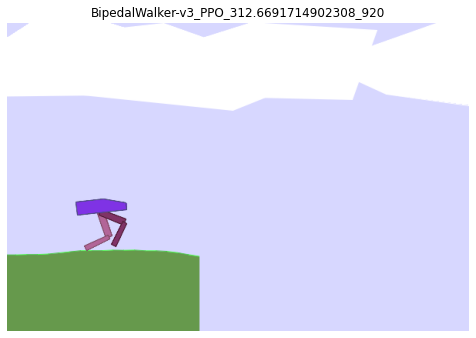

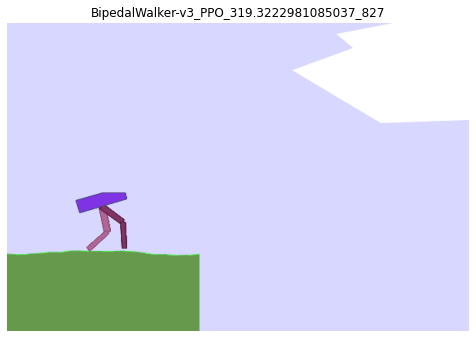

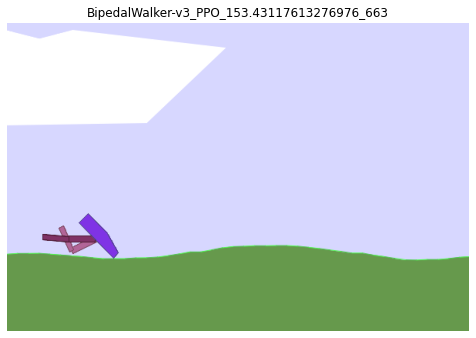

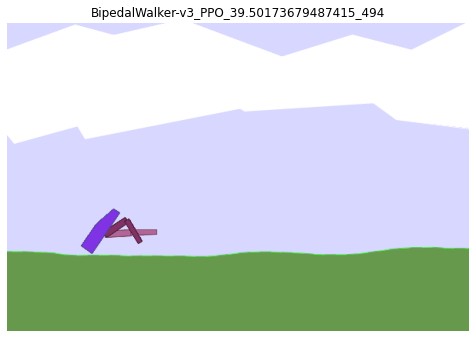

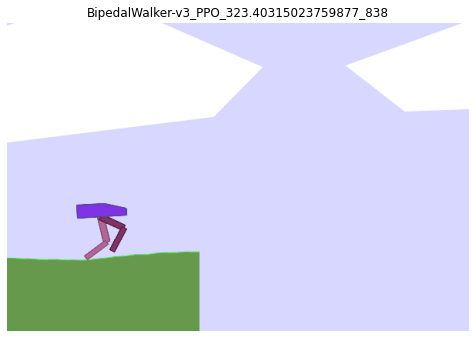

In [11]:
train(cfg)